In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

from einops import rearrange

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")

In [2]:
ckpt = "/home/twhit/bliss/WeakLensingFlowMatchingDC2/scaled_fm_lr0001_redbin3/checkpoints/encoder_230.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("config_dc2_redbin3_flowmatching", {
        "train.pretrained_weights=" + ckpt,
        })

seed = torch.randint(0, 1000, [1])
GlobalEnv.seed_in_this_program = seed

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()
num_batches = len(test_dl)

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [5]:
torch.manual_seed(0)

num_samples_per_image = 2000  # Reduced to manage memory
num_time_steps = 10

all_z_cpu = []
all_z1_cpu = []
all_batch_indices = []

ra = torch.zeros(len(test_dl), 8, 8, 3, device=device)
dec = torch.zeros(len(test_dl), 8, 8, 3, device=device)

for batch_idx, batch_data in enumerate(test_dl):
    print(f"Processing batch {batch_idx + 1}/{num_batches}")
    
    batch = move_data_to_device(batch_data, device)
    
    x_list = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
    x = torch.cat(x_list, dim=2)
    
    x_embedding = encoder.image_encoder(x)
    
    ra[batch_idx] = batch['tile_catalog']['ra'].squeeze()
    dec[batch_idx] = batch['tile_catalog']['dec'].squeeze()

    shear1 = 100 * rearrange(batch["tile_catalog"]['shear_1'], 'b h w r -> b r h w')
    shear2 = 100 * rearrange(batch["tile_catalog"]['shear_2'], 'b h w r -> b r h w')
    convergence = 100 * rearrange(batch["tile_catalog"]['convergence'], 'b h w r -> b r h w')
    z1 = torch.cat([shear1, shear2, convergence], dim=1)
    
    encoder.image_encoder = encoder.image_encoder.to(cpu_device)
    x = x.to(cpu_device)
    batch = move_data_to_device(batch, cpu_device)
    del x_list
    shear1, shear2, convergence = shear1.to(cpu_device), shear2.to(cpu_device), convergence.to(cpu_device)
    torch.cuda.empty_cache()
    
    t = torch.linspace(0.0, 1.0, num_time_steps + 1, device=device).view(-1, 1, 1).expand(-1, num_samples_per_image, 1)
    x_embedding_expanded = x_embedding.expand(num_samples_per_image, -1, z1.shape[-2], z1.shape[-1])
    z = torch.randn(num_samples_per_image, z1.shape[1], z1.shape[2], z1.shape[3], device=device)
    
    for i in range(num_time_steps):
        with torch.no_grad():
            z = encoder.sample_path(z, x_embedding_expanded, t[i], t[i+1], method='midpoint')
    
    all_z_cpu.append(z.to(cpu_device))
    all_z1_cpu.append(z1.to(cpu_device))
    all_batch_indices.append(batch_idx)

    del z, x_embedding_expanded, t, x_embedding, z1
    encoder.image_encoder = encoder.image_encoder.to(device)
    torch.cuda.empty_cache()
    
    print(f"Batch {batch_idx + 1} complete.")

Processing batch 1/40
Batch 1 complete.
Processing batch 2/40
Batch 2 complete.
Processing batch 3/40
Batch 3 complete.
Processing batch 4/40
Batch 4 complete.
Processing batch 5/40
Batch 5 complete.
Processing batch 6/40
Batch 6 complete.
Processing batch 7/40
Batch 7 complete.
Processing batch 8/40
Batch 8 complete.
Processing batch 9/40
Batch 9 complete.
Processing batch 10/40
Batch 10 complete.
Processing batch 11/40
Batch 11 complete.
Processing batch 12/40
Batch 12 complete.
Processing batch 13/40
Batch 13 complete.
Processing batch 14/40
Batch 14 complete.
Processing batch 15/40
Batch 15 complete.
Processing batch 16/40
Batch 16 complete.
Processing batch 17/40
Batch 17 complete.
Processing batch 18/40
Batch 18 complete.
Processing batch 19/40
Batch 19 complete.
Processing batch 20/40
Batch 20 complete.
Processing batch 21/40
Batch 21 complete.
Processing batch 22/40
Batch 22 complete.
Processing batch 23/40
Batch 23 complete.
Processing batch 24/40
Batch 24 complete.
Processing

In [6]:
# Stack all samples and ground truth
z_cpu = torch.cat([l.unsqueeze(0) for l in all_z_cpu], dim=0).flip(dims=[-2,-1])
z1_cpu = torch.cat(all_z1_cpu, dim=0).unsqueeze(1).flip(dims=[-2,-1])
ra = ra.flip(dims=[1,2]).cpu()
dec = dec.flip(dims=[1,2]).cpu()

# Clean up intermediate lists to free memory
del all_z_cpu, all_z1_cpu, all_batch_indices

In [7]:
encoder.image_encoder = encoder.image_encoder.to(cpu_device)
torch.cuda.empty_cache()

In [8]:
mask = (dec[...,0] > -36.4).all([-1,-2])
ra_subset = ra[mask]
dec_subset = dec[mask]
shear1_true_subset = rearrange(z1_cpu.squeeze()[:,0:3][mask], 'b d h w -> b h w d') / 100
shear1_pred_subset = rearrange(z_cpu[:,:,0:3][mask], 'b n d h w -> b n h w d') / 100
shear2_true_subset = rearrange(z1_cpu.squeeze()[:,3:6][mask], 'b d h w -> b h w d') / 100
shear2_pred_subset = rearrange(z_cpu[:,:,3:6][mask], 'b n d h w -> b n h w d') / 100
convergence_true_subset = rearrange(z1_cpu.squeeze()[:,6:9][mask], 'b d h w -> b h w d') / 100
convergence_pred_subset = rearrange(z_cpu[:,:,6:9][mask], 'b n d h w -> b n h w d') / 100

In [9]:
ra_mean = ra_subset[...,0].mean([-1,-2])
dec_mean = dec_subset[...,0].mean([-1,-2])
radec_mean = torch.stack((ra_mean, dec_mean), dim=-1)
sorted_indices = torch.argsort(- radec_mean[:,1] * 1e5 + radec_mean[:,0])

In [10]:
ra_subset_sorted = rearrange(ra_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
dec_subset_sorted = rearrange(dec_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_true_subset_sorted = rearrange(shear1_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_pred_subset_sorted = rearrange(shear1_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")
shear2_true_subset_sorted = rearrange(shear2_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear2_pred_subset_sorted = rearrange(shear2_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")
convergence_true_subset_sorted = rearrange(convergence_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
convergence_pred_subset_sorted = rearrange(convergence_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")

In [11]:
torch.save(shear1_pred_subset_sorted, "fm_shear1_pred_subset_sorted.pt")
torch.save(shear2_pred_subset_sorted, "fm_shear2_pred_subset_sorted.pt")
torch.save(convergence_pred_subset_sorted, "fm_convergence_pred_subset_sorted.pt")

In [12]:
vmin = -0.06
vmax = 0.06
fontsize = 32
ticklabelsize = 16
interpolation = 'none'

extent = [ra_subset_sorted.min().cpu(), ra_subset_sorted.max().cpu(),
          dec_subset_sorted.min().cpu(), dec_subset_sorted.max().cpu()]

/tmp/ipykernel_1541298/2012414780.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  _ = fig.tight_layout()


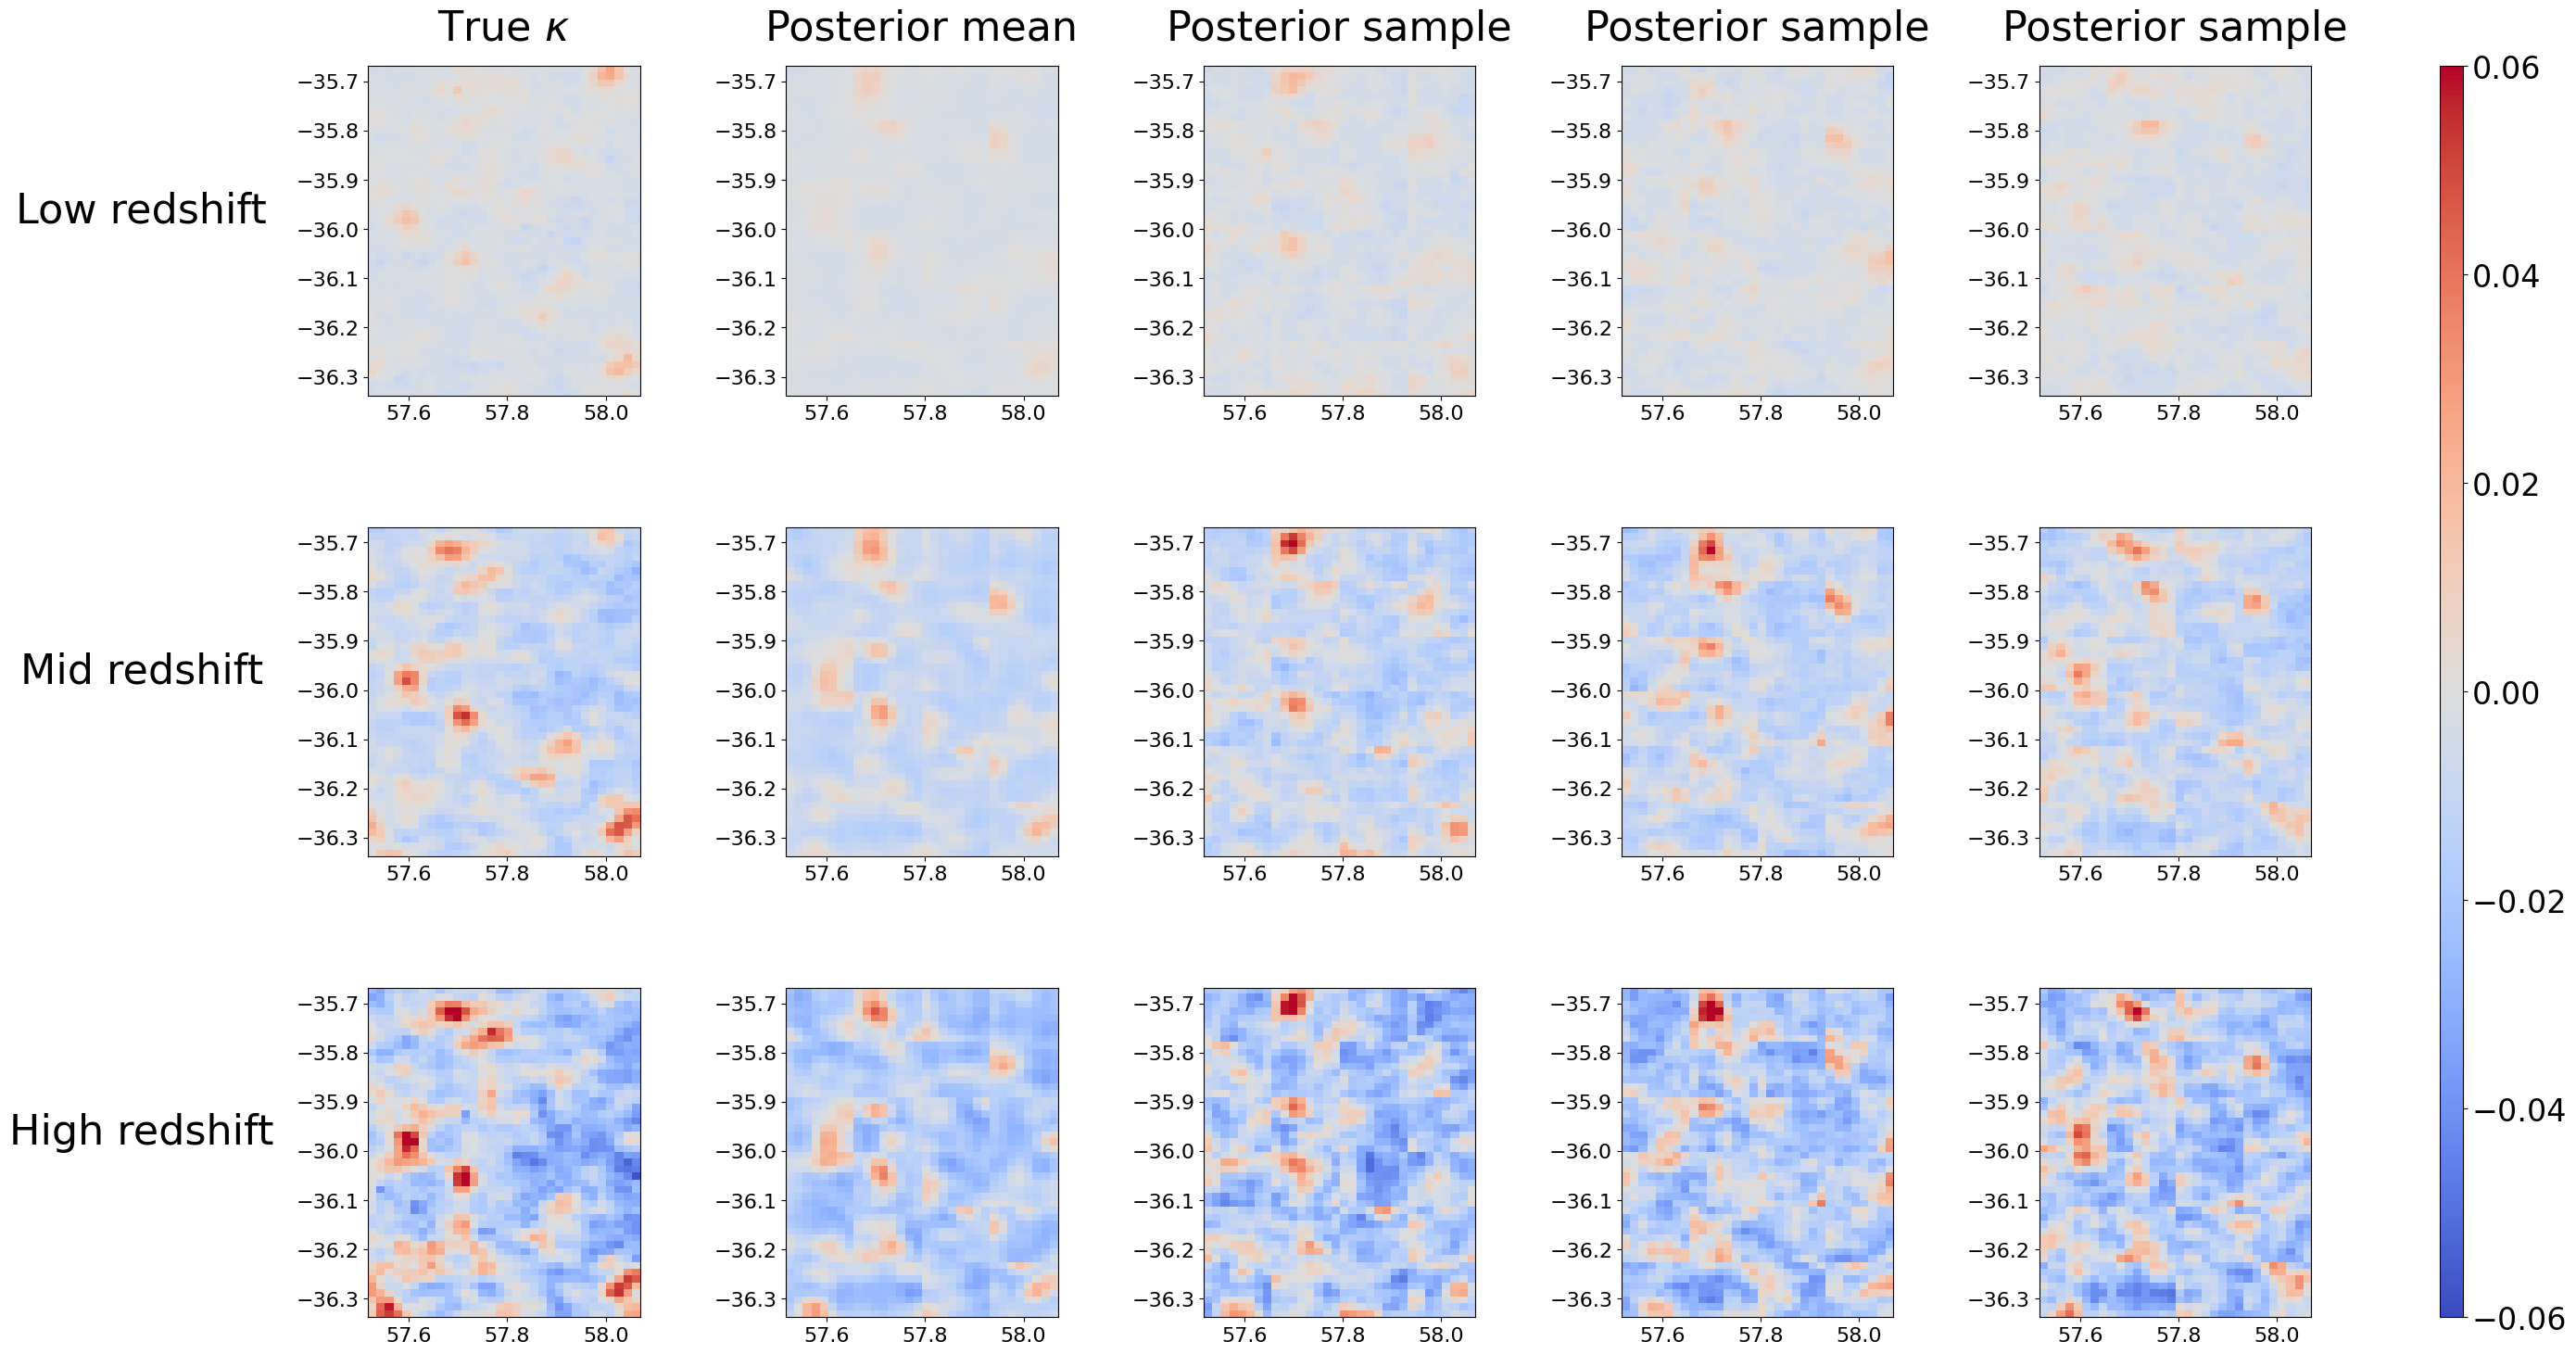

In [13]:
fig, ax = plt.subplots(3, 5, figsize = (25,15))

torch.manual_seed(42)

sample_idx = torch.randint(0, num_samples_per_image, [3])

for b in range(3):
    # True
    _ = ax[b,0].imshow(convergence_true_subset_sorted[...,b].cpu(), extent = extent,
                    interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Posterior mean
    _ = ax[b,1].imshow(convergence_pred_subset_sorted.mean(-1)[...,b].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 1
    _ = ax[b,2].imshow(convergence_pred_subset_sorted[...,b,sample_idx[0]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 2
    _ = ax[b,3].imshow(convergence_pred_subset_sorted[...,b,sample_idx[1]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 3
    tmp = ax[b,4].imshow(convergence_pred_subset_sorted[...,b,sample_idx[2]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')

_ = ax[0,0].set_title('True $\kappa$', fontsize = fontsize, pad = 20)
_ = ax[0,1].set_title('Posterior mean', fontsize = fontsize, pad = 20)
_ = ax[0,2].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,3].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,4].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,0].set_ylabel('Low redshift', fontsize = fontsize, rotation = 0, labelpad = 120)
_ = ax[1,0].set_ylabel('Mid redshift', fontsize = fontsize, rotation = 0, labelpad = 120)
_ = ax[2,0].set_ylabel('High redshift', fontsize = fontsize, rotation = 0, labelpad = 120)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize = 0.5 * (ticklabelsize + fontsize))
fig.colorbar(tmp, cax=cbar_ax)

_ = fig.tight_layout()

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.01, hspace=0.4)

for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=ticklabelsize)